In [ ]:
# Import the 'drive' module from Google Colab to access Google Drive
from google.colab import drive

# Mount Google Drive to the Colab environment at the specified path
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Copy the dataset ZIP file from Google Drive to the local environment
!cp "/content/drive/My Drive/FYP_Project/CBIS_DDSM.zip" .
# Unzip the dataset quietly (suppress output)
!unzip -qq CBIS_DDSM.zip
# Remove the ZIP file after extraction to save storage space
!rm CBIS_DDSM.zip
# Set the dataset directory path
cbis_path = 'CBIS_DDSM'


In [ ]:
# Install TensorFlow
!pip install tensorflow -qq
!pip install pydot graphviz -qq


In [ ]:
# Import all necessary Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, Input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

In [ ]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to 0->mass 1->calcification
    """
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [ ]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 256
test_images = test_images.astype('uint16') / 256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

Train size: 2676 	 Test size: 336
Image size: 150x150


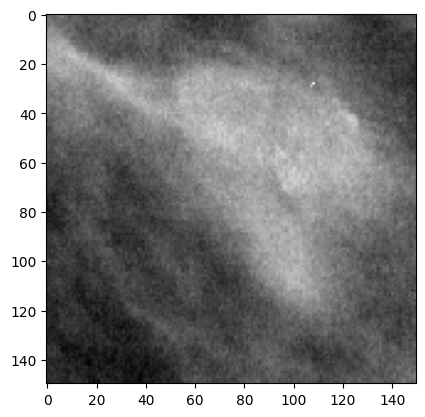

Label: 1


In [ ]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

In [ ]:
def create_vgg16(verbose=False, fc_size=256, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(150, 150, 3))

    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(1, activation='sigmoid'))

    # Freeze the convolutional base
    vgg16_base.trainable = False

    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

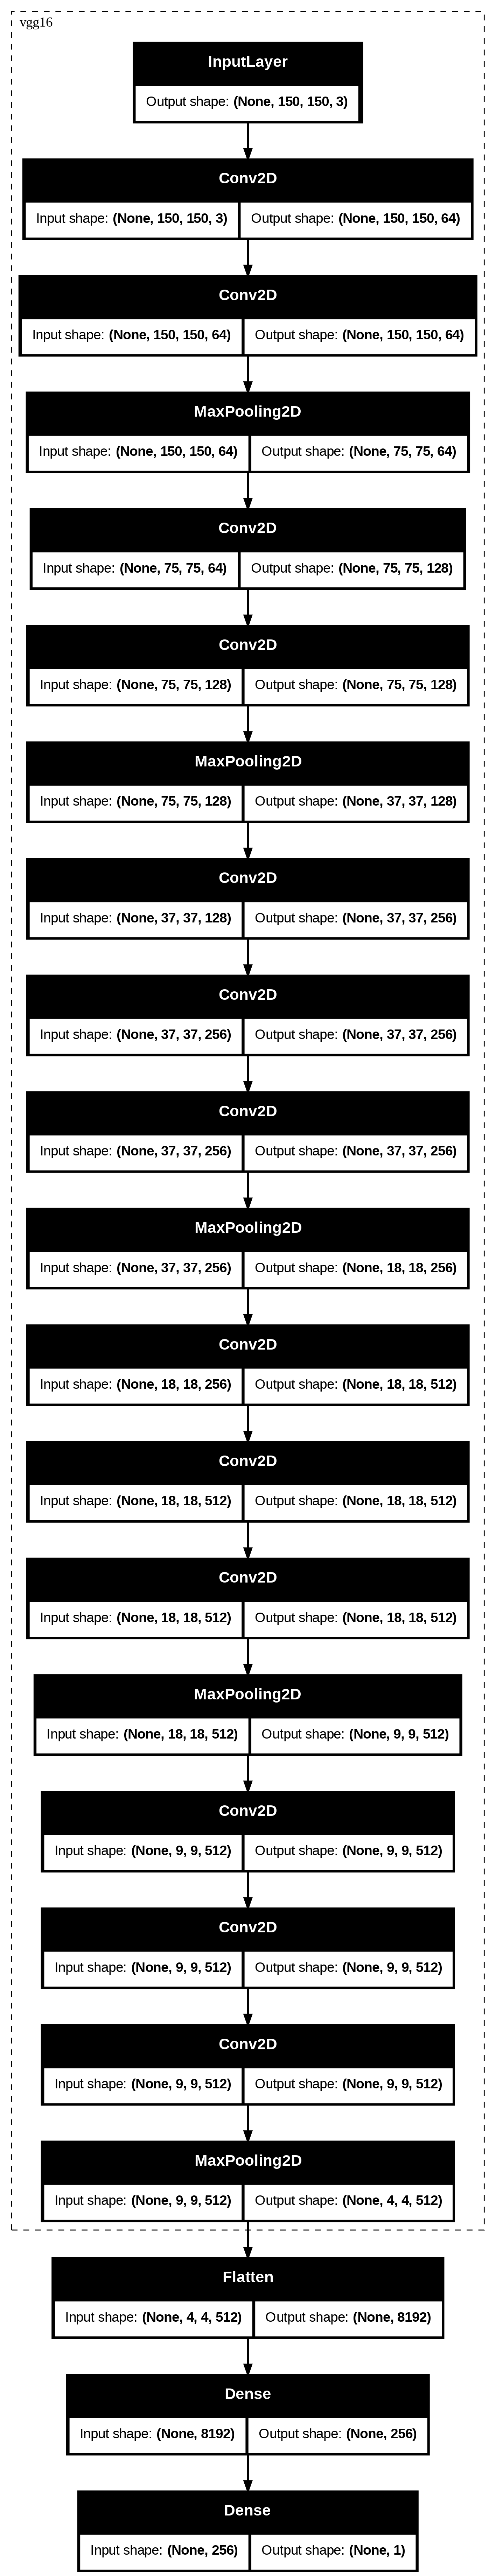

In [ ]:
# Show the VGG16 architecture

vgg16_example = create_vgg16(verbose=True)
plot_model(vgg16_example, to_file='vgg16.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True)


In [ ]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe = create_vgg16()

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_2cl_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_vgg16_fe = vgg16_fe.fit(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(vgg16_fe, 'vgg16_fe_2cl_end.keras')
!cp vgg16_fe* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 2s 705ms/step - accuracy: 0.6547 - loss: 4.5188

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.41942, saving model to vgg16_fe_2cl_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 901ms/step - accuracy: 0.6653 - loss: 4.1701 - val_accuracy: 0.8262 - val_loss: 0.4194
Epoch 2/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step - accuracy: 0.8087 - loss: 0.4418
Epoch 2: val_loss improved from 0.41942 to 0.35580, saving model to vgg16_fe_2cl_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 670ms/step - accuracy: 0.8073 - loss: 0.4431 - val_accuracy: 0.8393 - val_loss: 0.3558
Epoch 3/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step - accuracy: 0.8269 - loss: 0.4049
Epoch 3: val_loss did not improve from 0.35580
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 646ms/step - accuracy: 0.8281 - loss: 0.4035 - val_accuracy: 0.7159 - val_loss: 0.5726
Epoch 4/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - accuracy: 0.8030 - loss: 0.4186
Epoch 4: val_loss improved from 0.35580 to 0.34644, saving model to vgg16_fe_2cl_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 666ms/step - accuracy: 0.8056 - lo

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe.history['loss']
tra_acc_fe = history_vgg16_fe.history['accuracy']  # Correct key for accuracy
val_loss_fe = history_vgg16_fe.history['val_loss']
val_acc_fe = history_vgg16_fe.history['val_accuracy']  # Correct key for validation accuracy

# Total number of epochs in training
epochs_fe = range(1, len(tra_acc_fe) + 1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when the validation loss reached its minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1  # Adding 1 to match epoch numbering

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe - 1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe - 1]

# Load the best model based on validation loss
opt_vgg16_fe = models.load_model('vgg16_fe_2cl_best.keras')

# Evaluate on test set
test_loss_fe, test_acc_fe = vgg16_fe.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe.evaluate(test_images, test_labels, verbose=False)

# Print out results
print("VGG16 Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)


VGG16 Feature Extraction

Epoch [end]: 73
Epoch [opt]: 43
Valid accuracy [end]: 0.8953
Valid accuracy [opt]: 0.9028
Test accuracy [end]:  0.8899
Test accuracy [opt]:  0.8601
Valid loss [end]: 0.3468
Valid loss [opt]: 0.2611
Test loss [end]:  0.4231
Test loss [opt]:  0.3887


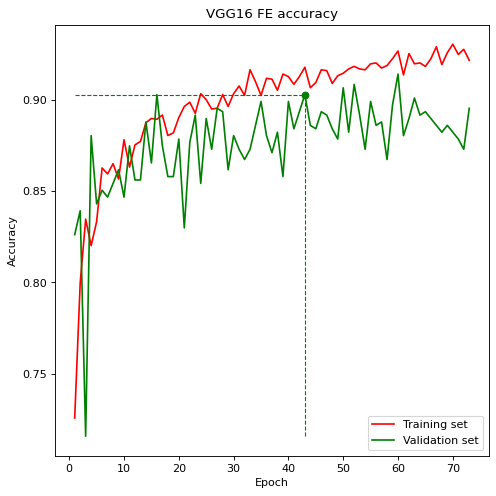

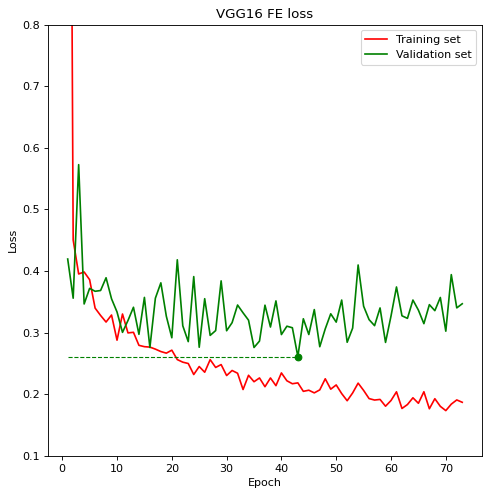

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.1,0.8)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop = create_vgg16(dropout=0.5)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_2cl_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_vgg16_fe_drop = vgg16_fe_drop.fit(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(vgg16_fe_drop, 'vgg16_fe_drop_2cl_end.keras')
!cp vgg16_fe* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step - accuracy: 0.6495 - loss: 3.8649
Epoch 1: val_loss improved from inf to 0.49070, saving model to vgg16_fe_drop_2cl_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 747ms/step - accuracy: 0.6602 - loss: 3.5798 - val_accuracy: 0.7720 - val_loss: 0.4907
Epoch 2/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step - accuracy: 0.8008 - loss: 0.4443
Epoch 2: val_loss improved from 0.49070 to 0.43410, saving model to vgg16_fe_drop_2cl_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 675ms/step - accuracy: 0.7998 - loss: 0.4479 - val_accuracy: 0.7850 - val_loss: 0.4341
Epoch 3/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step - accuracy: 0.7784 - loss: 0.4817
Epoch 3: val_loss improved from 0.43410 to 0.37148, saving model to vgg16_fe_drop_2cl_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 667ms/step - accuracy: 0.7804 - loss: 0.4793 - val_accuracy: 0.8486 - val_loss: 0.3715
Epoch 4/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step - accuracy: 0.8094 - loss: 0.4289
Epoch 4: va

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop.history['loss']
tra_acc_fe = history_vgg16_fe_drop.history['accuracy']  # Corrected accuracy key
val_loss_fe = history_vgg16_fe_drop.history['val_loss']
val_acc_fe = history_vgg16_fe_drop.history['val_accuracy']  # Corrected validation accuracy key

# Total number of epochs in training
epochs_fe = range(1, len(tra_acc_fe) + 1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when the validation loss reached its minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1  # Adjust to match 1-based epoch

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe - 1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe - 1]

# Load the best model based on validation loss
opt_vgg16_fe_drop = models.load_model('vgg16_fe_drop_2cl_best.keras')

# Evaluate the model on the test set
test_loss_fe, test_acc_fe = vgg16_fe_drop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop.evaluate(test_images, test_labels, verbose=False)

# Print out results
print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)


VGG16 (w/ dropout) Feature Extraction

Epoch [end]: 96
Epoch [opt]: 66
Valid accuracy [end]: 0.9028
Valid accuracy [opt]: 0.9047
Test accuracy [end]:  0.8661
Test accuracy [opt]:  0.8750
Valid loss [end]: 0.2648
Valid loss [opt]: 0.2500
Test loss [end]:  0.3753
Test loss [opt]:  0.3987


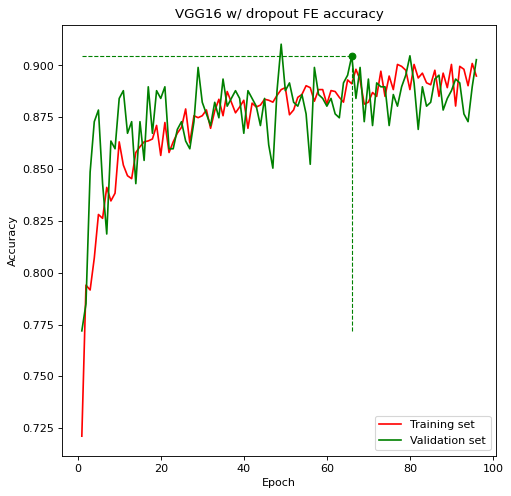

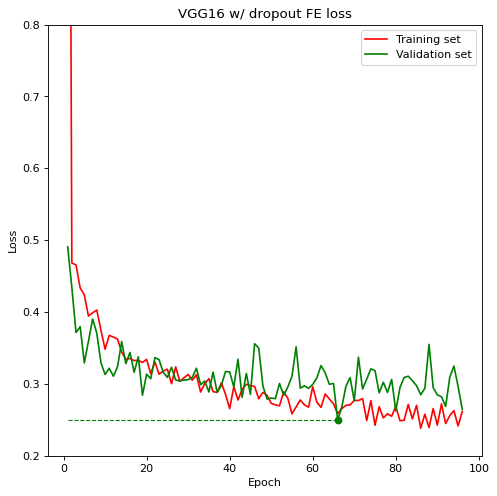

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.2, 0.8)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_2cl_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_2cl_end.keras')
!cp vgg16_fe* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step - accuracy: 0.6234 - loss: 2.2217
Epoch 1: val_loss improved from inf to 0.44087, saving model to vgg16_fe_drop_128_2cl_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 747ms/step - accuracy: 0.6356 - loss: 2.0863 - val_accuracy: 0.8355 - val_loss: 0.4409
Epoch 2/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - accuracy: 0.7794 - loss: 0.4777
Epoch 2: val_loss improved from 0.44087 to 0.41599, saving model to vgg16_fe_drop_128_2cl_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 664ms/step - accuracy: 0.7829 - loss: 0.4751 - val_accuracy: 0.8075 - val_loss: 0.4160
Epoch 3/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - accuracy: 0.8054 - loss: 0.4561
Epoch 3: val_loss improved from 0.41599 to 0.39072, saving model to vgg16_fe_drop_128_2cl_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 663ms/step - accuracy: 0.8062 - loss: 0.4547 - val_accuracy: 0.8299 - val_loss: 0.3907
Epoch 4/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step - accuracy: 0.8012 - loss: 0.4447

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']  # Corrected 'acc' to 'accuracy'
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']  # Corrected 'val_acc' to 'val_accuracy'

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe) + 1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1  # +1 for 1-based index

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe - 1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe - 1]

# Load the best model based on validation loss
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_2cl_best.keras')

# Evaluate the model on the test set
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

# Print out results
print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]: %.4f" % opt_test_loss_fe)


VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 62
Epoch [opt]: 42
Valid accuracy [end]: 0.8785
Valid accuracy [opt]: 0.8916
Test accuracy [end]:  0.8631
Test accuracy [opt]:  0.8571
Valid loss [end]: 0.3064
Valid loss [opt]: 0.2611
Test loss [end]:  0.3739
Test loss [opt]: 0.3740


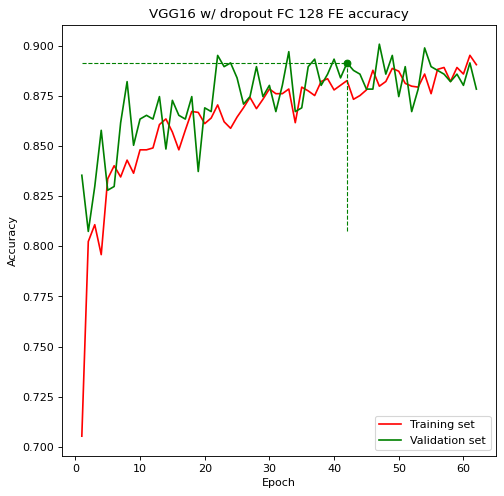

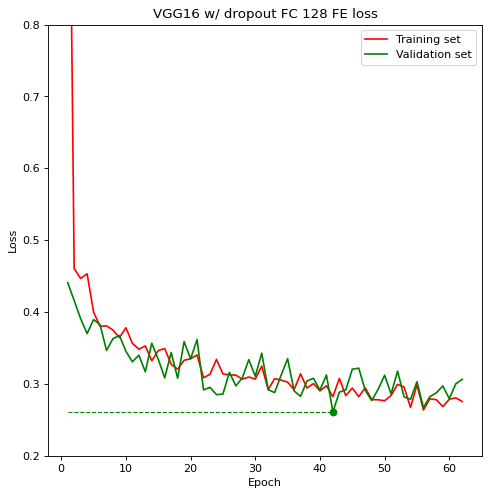

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.2, 0.8)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# New generator with more aggressive data augmentation parameters
train_datagen_hardaugm = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

train_datagen_hardaugm.fit(train_images)

train_generator_hardaugm = train_datagen_hardaugm.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator_hardaugm = train_datagen_hardaugm.flow(train_images, train_labels, batch_size=128, subset='validation')


In [ ]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_hardaugm = create_vgg16(dropout=0.5)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_hardaugm_2cl_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_hardaugm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_vgg16_fe_hardaugm = vgg16_fe_hardaugm.fit(
        train_generator_hardaugm,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator_hardaugm,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(vgg16_fe_hardaugm, 'vgg16_fe_hardaugm_2cl_end.keras')
!cp vgg16_fe* "/content/drive/My Drive/FYP_Project/models/"


Epoch 1/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step - accuracy: 0.6452 - loss: 2.7780
Epoch 1: val_loss improved from inf to 0.56520, saving model to vgg16_fe_hardaugm_2cl_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 757ms/step - accuracy: 0.6528 - loss: 2.6194 - val_accuracy: 0.7140 - val_loss: 0.5652
Epoch 2/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - accuracy: 0.7918 - loss: 0.5041
Epoch 2: val_loss improved from 0.56520 to 0.46635, saving model to vgg16_fe_hardaugm_2cl_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 675ms/step - accuracy: 0.7914 - loss: 0.5042 - val_accuracy: 0.8075 - val_loss: 0.4663
Epoch 3/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step - accuracy: 0.7642 - loss: 0.5101
Epoch 3: val_loss did not improve from 0.46635
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 659ms/step - accuracy: 0.7654 - loss: 0.5070 - val_accuracy: 0.7290 - val_loss: 0.5365
Epoch 4/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step - accuracy: 0.7738 - loss: 0.5009
Epoch 4: val_loss improved from 0.46635 to 0.43933, s

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_hardaugm.history['loss']
tra_acc_fe = history_vgg16_fe_hardaugm.history['accuracy']  # Corrected 'acc' to 'accuracy'
val_loss_fe = history_vgg16_fe_hardaugm.history['val_loss']
val_acc_fe = history_vgg16_fe_hardaugm.history['val_accuracy']  # Corrected 'val_acc' to 'val_accuracy'

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe) + 1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1  # +1 for 1-based index

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe - 1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe - 1]

# Loss and accuracy on the test set
opt_vgg16_fe_hardaugm = models.load_model('vgg16_fe_hardaugm_2cl_best.keras')

# Evaluate on the test set
test_loss_fe, test_acc_fe = vgg16_fe_hardaugm.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_hardaugm.evaluate(test_images, test_labels, verbose=False)

# Print out results
print("VGG16 (w/ dropout, hard augmentation) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]: %.4f" % opt_test_loss_fe)


VGG16 (w/ dropout, hard augmentation) Feature Extraction

Epoch [end]: 66
Epoch [opt]: 36
Valid accuracy [end]: 0.8561
Valid accuracy [opt]: 0.8673
Test accuracy [end]:  0.8631
Test accuracy [opt]:  0.8542
Valid loss [end]: 0.3259
Valid loss [opt]: 0.3220
Test loss [end]:  0.3597
Test loss [opt]: 0.3681


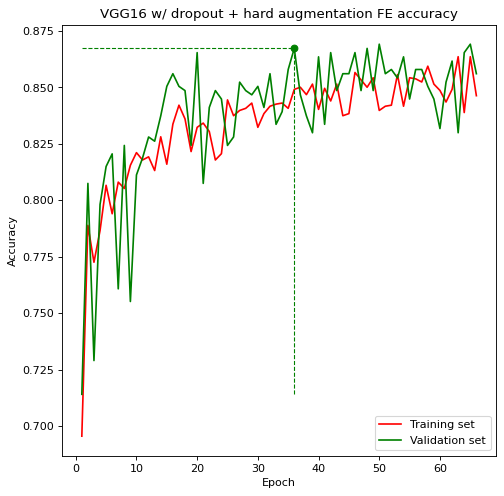

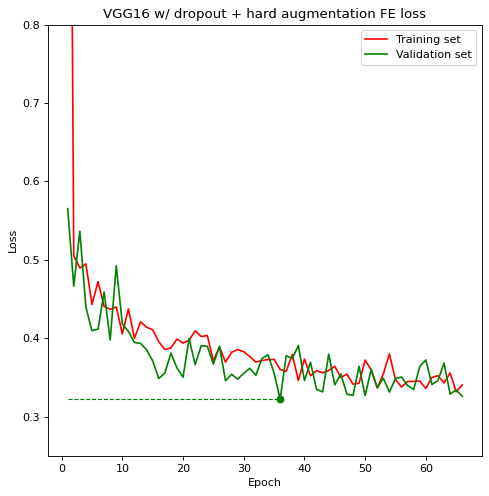

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout + hard augmentation FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout + hard augmentation FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.25, 0.8)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
!cp "/content/drive/My Drive/FYP_Project/models/vgg16_fe_hardaugm_2cl_best.keras" .
vgg16_ft_1layer = models.load_model('vgg16_fe_hardaugm_2cl_best.keras')

# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 4,457,473 (17.00 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_2cl_best.keras',
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True,
        save_freq='epoch')

# Train
history_ft = vgg16_ft_1layer.fit(
        train_generator_hardaugm,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator_hardaugm,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_2cl_end.keras')
!cp vgg16_ft* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step - accuracy: 0.8298 - loss: 0.4297
Epoch 1: val_loss improved from inf to 0.36968, saving model to vgg16_ft_1layer_2cl_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 789ms/step - accuracy: 0.8305 - loss: 0.4260 - val_accuracy: 0.8636 - val_loss: 0.3697
Epoch 2/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - accuracy: 0.8406 - loss: 0.3495
Epoch 2: val_loss improved from 0.36968 to 0.33827, saving model to vgg16_ft_1layer_2cl_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 677ms/step - accuracy: 0.8425 - loss: 0.3466 - val_accuracy: 0.8692 - val_loss: 0.3383
Epoch 3/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - accuracy: 0.8630 - loss: 0.3331
Epoch 3: val_loss did not improve from 0.33827
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 657ms/step - accuracy: 0.8621 - loss: 0.3344 - val_accuracy: 0.8692 - val_loss: 0.3465
Epoch 4/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step - accuracy: 0.8567 - loss: 0.3342
Epoch 4: val_loss improved from 0.33827 to 0.30481, savin

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']  # Corrected 'acc' to 'accuracy'
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']  # Corrected 'val_acc' to 'val_accuracy'

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe) + 1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1  # +1 for 1-based index

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe - 1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe - 1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_2cl_best.keras')

# Evaluate on the test set
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

# Print out results
print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]: %.4f" % opt_test_loss_fe)


VGG16 Fine Tuning

Epoch [end]: 122
Epoch [opt]: 92
Valid accuracy [end]: 0.9047
Valid accuracy [opt]: 0.9290
Test accuracy [end]:  0.8780
Test accuracy [opt]:  0.8869
Valid loss [end]: 0.2709
Valid loss [opt]: 0.2255
Test loss [end]:  0.3132
Test loss [opt]: 0.2972


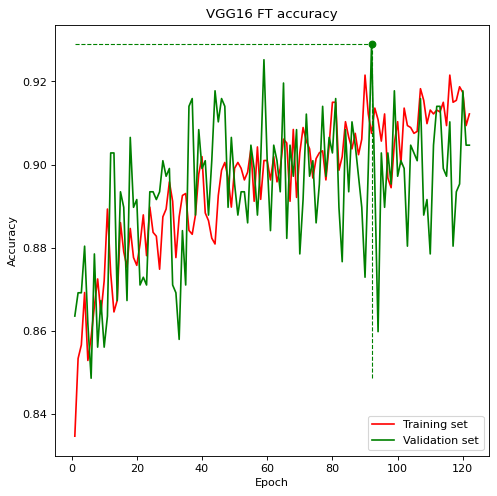

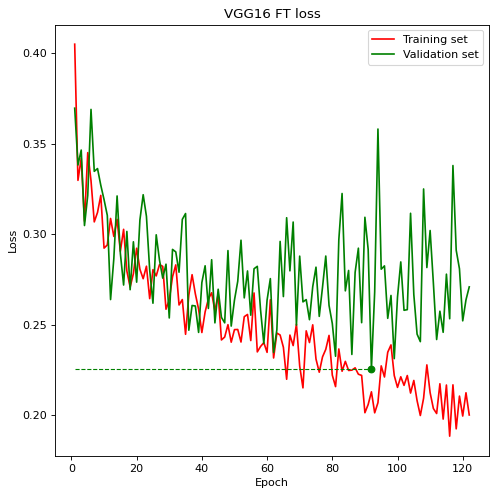

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
!cp "/content/drive/My Drive/FYP_Project/models/vgg16_ft_1layer_2cl_best.keras" .
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_2cl_best.keras')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 6,817,281 (26.01 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_2cl_best.keras',
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True,
        save_freq='epoch')

# Train
history_ft_2layer = vgg16_ft_2layer.fit(
        train_generator_hardaugm,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator_hardaugm,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_2cl_end.keras')
!cp vgg16_ft* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step - accuracy: 0.8321 - loss: 0.5300
Epoch 1: val_loss improved from inf to 0.42762, saving model to vgg16_ft_2layer_2cl_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 793ms/step - accuracy: 0.8357 - loss: 0.5130 - val_accuracy: 0.8037 - val_loss: 0.4276
Epoch 2/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - accuracy: 0.8803 - loss: 0.2797
Epoch 2: val_loss improved from 0.42762 to 0.24036, saving model to vgg16_ft_2layer_2cl_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 681ms/step - accuracy: 0.8791 - loss: 0.2839 - val_accuracy: 0.9271 - val_loss: 0.2404
Epoch 3/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step - accuracy: 0.8908 - loss: 0.2629
Epoch 3: val_loss did not improve from 0.24036
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 656ms/step - accuracy: 0.8884 - loss: 0.2676 - val_accuracy: 0.8505 - val_loss: 0.3304
Epoch 4/200
17/20 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step - accuracy: 0.8776 - loss: 0.2603
Epoch 4: val_loss did not improve from 0.24036
20/20 ━━━━

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']  # Corrected 'acc' to 'accuracy'
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']  # Corrected 'val_acc' to 'val_accuracy'

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe) + 1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1  # +1 for 1-based index

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe - 1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe - 1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_2cl_best.keras')

# Evaluate on the test set
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

# Print out results
print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]: %.4f" % opt_test_loss_fe)


VGG16 Fine Tuning (2 layers)

Epoch [end]: 78
Epoch [opt]: 48
Valid accuracy [end]: 0.9308
Valid accuracy [opt]: 0.9234
Test accuracy [end]:  0.8988
Test accuracy [opt]:  0.8929
Valid loss [end]: 0.2220
Valid loss [opt]: 0.2132
Test loss [end]:  0.4434
Test loss [opt]: 0.3385


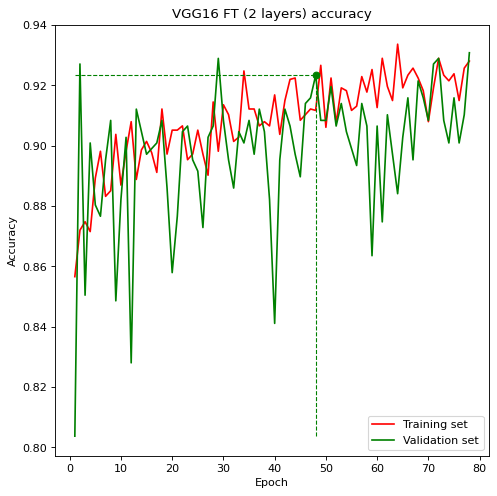

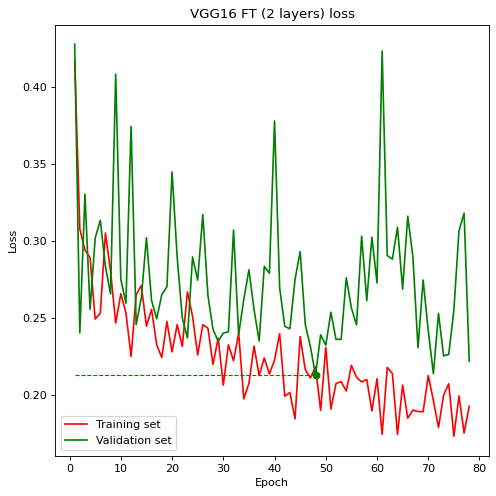

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();